In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
base_model = [
    #expand_ratio, channels, repeats, stride,kernel_size
    [1,16,1,1,3],
    [6,24,2,2,3],
    [6,40,2,2,5],
    [6,80,3,2,3],
    [6,112,3,1,5],
    [6,192,4,2,5],
    [6,320,1,1,3],
]

In [ ]:
phi_values = {
    #phi values of all the variations of efficientNet
    "b0": (0,224,0.2),
    "b1": (0.5,240,0.2),
    "b2":(1,260,0.3),
    "b3":(1,260,0.3),
    "b4":(3,380,0.4),
    "b5":(4,456,0.4),
    "b6":(5,528,0.5),
    "b7":(6,600,0.5),
}

In [ ]:
class InitialBlock(nn.Module):
  def __init__(self,in_channels, out_channels, kernel_size, stride, padding, groups):
    super(InitialBlock,self).__init__()
    self.cnn = nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        groups=groups,
        bias=False
    )
    self.bn = nn.BatchNorm2d(out_channels)
    self.silu = nn.SiLU()


  def forward(self,x):
    return self.silu(self.bn(self.cnn(x)))


In [ ]:
class SqueezeExcitation(nn.Module):
  def __init__(self, in_channels, reduced_dim):
    super(SqueezeExcitation , self).__init__()
    self.se = nn.Sequential(
        nn.AdaptiveAvgPool2d(1), # I/P: CxHxW -> O/P: Cx1x1 (C-> No.of channels , H->Height, W->Width)
        nn.Conv2d(in_channels,reduced_dim,1),
        nn.SiLU(),
        nn.Conv2d(reduced_dim , in_channels,1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    return x*self.se(x)


In [ ]:
 # reduction part is for telling the squeeze excitation how much it should reduced dimensionality of the image, survival_prob is for stochastic depth
class MB(nn.Module):
  def __init__(
      self,in_channels,out_channels,kernel_size,stride,padding,expand_ratio,reduction=4 ,survival_prob=0.8
  ):
    super(MB,self).__init__()
    self.survival_prob = survival_prob
    self.use_residual = in_channels == out_channels and stride == 1
    hidden_dim = in_channels*expand_ratio
    self.expand = in_channels !=hidden_dim
    reduced_dim = int(in_channels/reduction)

    self.conv = nn.Sequential(
              # Initial expansion if necessary
              InitialBlock(in_channels, hidden_dim, kernel_size=3, stride=1, padding=1, groups=1) if self.expand else nn.Identity(),
              # Depthwise convolution
              InitialBlock(hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim),
              # Squeeze-and-Excitation
              SqueezeExcitation(hidden_dim, reduced_dim),
              # Pointwise convolution
              nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
              nn.BatchNorm2d(out_channels)
          )

  def stochastic_depth(self,x):
    if not self.training:
      return x


    binary_tensor = torch.rand(x.shape[0],1,1,1,device=x.device) < self.survival_prob

    return torch.div(x,self.survival_prob) * binary_tensor


  def forward(self,inputs):
    x = self.conv(inputs)


    if not hasattr(self, 'conv'):
        raise RuntimeError("'conv' attribute is not defined in the MB block.")


    if self.use_residual:
      return self.stochastic_depth(x) + inputs
    else:
      return x


In [ ]:
class EfficientNET(nn.Module):
  def __init__(self,version,num_classes):
    super(EfficientNET, self).__init__()
    width_factor,depth_factor,dropout_rate = self.calculate_factors((version))
    last_channels = ceil(1280*width_factor)
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.features = self.create_features(width_factor,depth_factor,last_channels)
    self.classifier = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(last_channels,num_classes),
        nn.Softmax(dim=1)
    )



  def calculate_factors(self,version,alpha=1.2, beta=1.1):
    phi,res,drop_rate = phi_values[version]
    depth_factor = alpha ** phi
    width_factor = beta ** phi
    return width_factor,depth_factor,drop_rate

  def create_features(self,width_factor,depth_factor,last_channels):
    channels = int(32*width_factor)
    features = [InitialBlock(3,channels,3,stride=2,padding=1,groups=1)]
    in_channels = channels

    for expand_ratio, channels,repeats,stride,kernel_size in base_model:
      out_channels = 4*ceil(int(channels*width_factor)/4)
      layers_repeats = ceil(repeats*depth_factor)

      for layer in range(layers_repeats):
        features.append(
            MB(
                in_channels,
                out_channels,
                expand_ratio=expand_ratio,
                stride=stride if layer == 0 else 1,
                kernel_size=kernel_size,
                padding=kernel_size//2, #in this basically if we have a kernel of 1,we need padding 0 for same dimension image, if kernel is of size 3 then padding should be of order 1 to get same dimensional output image. so her we take the integer divison by 2 meaning if 1//2 then answer is 0, 3//2 then asnwer is 1
            )
        )
        in_channels = out_channels


    features.append(
        InitialBlock(in_channels,last_channels,kernel_size=1,stride=1,padding=0,groups=1) #for the last conv layer
    )

    return nn.Sequential(*features)


  def forward(self,x):
    x = self.pool(self.features(x))
    return self.classifier(x.view(x.shape[0],-1))




In [ ]:
import os
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF

# Define the path to your original dataset
original_data_dir = '/content/drive/MyDrive/autism/consolidated'

# Define the path to the new folder where you want to save the augmented images
augmented_data_dir = '/content/drive/MyDrive/autism/augmented'

# Create the new folder if it doesn't exist
if not os.path.exists(augmented_data_dir):
    os.makedirs(augmented_data_dir)

# Define the data augmentation transforms
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(300), # Adjusted to 300x300
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Iterate over the subfolders in the original dataset
for class_name in os.listdir(original_data_dir):
    class_dir = os.path.join(original_data_dir, class_name)
    if os.path.isdir(class_dir):
        # Create a corresponding subfolder in the augmented directory
        augmented_class_dir = os.path.join(augmented_data_dir, class_name)
        if not os.path.exists(augmented_class_dir):
            os.makedirs(augmented_class_dir)

        # Iterate over the images in the class subfolder
        for filename in os.listdir(class_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"): # Check if the file is an image
                # Load the image
                img_path = os.path.join(class_dir, filename)
                img = Image.open(img_path)

                # Apply the data augmentation transforms
                augmented_img = data_transforms(img)

                # Convert the tensor back to a PIL Image
                augmented_img_pil = TF.to_pil_image(augmented_img)

                # Save the augmented image to the corresponding subfolder in the new folder
                augmented_img_path = os.path.join(augmented_class_dir, filename)
                augmented_img_pil.save(augmented_img_path)

KeyboardInterrupt: 

In [ ]:
import os
import shutil
import time

# Define the path to the combined dataset folder
combined_data_dir = '/content/drive/MyDrive/autism/combined_dataset'

# Create the combined dataset folder if it doesn't exist
if not os.path.exists(combined_data_dir):
    os.makedirs(combined_data_dir)

# Copy the original images to the combined dataset folder
for class_name in os.listdir(original_data_dir):
    class_dir = os.path.join(original_data_dir, class_name)
    if os.path.isdir(class_dir):
        # Create a corresponding subfolder in the combined dataset folder
        combined_class_dir = os.path.join(combined_data_dir, class_name)
        if not os.path.exists(combined_class_dir):
            os.makedirs(combined_class_dir)

        # Copy the images from the original class subfolder to the combined class subfolder
        for filename in os.listdir(class_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"): # Check if the file is an image
                src_path = os.path.join(class_dir, filename)
                dst_path = os.path.join(combined_class_dir, filename)
                shutil.copy(src_path, dst_path)

# Add the augmented images to the combined dataset folder
for class_name in os.listdir(augmented_data_dir):
    augmented_class_dir = os.path.join(augmented_data_dir, class_name)
    if os.path.isdir(augmented_class_dir):
        # Find the corresponding subfolder in the combined dataset folder
        combined_class_dir = os.path.join(combined_data_dir, class_name)

        # Copy the augmented images to the combined class subfolder
        for filename in os.listdir(augmented_class_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"): # Check if the file is an image
                src_path = os.path.join(augmented_class_dir, filename)
                dst_path = os.path.join(combined_class_dir, filename)
                # Check if the file already exists in the destination
                if os.path.exists(dst_path):
                    # Append a unique identifier to the filename
                    base, ext = os.path.splitext(filename)
                    new_filename = f"{base}_{int(time.time())}" + ext
                    dst_path = os.path.join(combined_class_dir, new_filename)
                shutil.copy(src_path, dst_path)


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

data_transforms_eff = transforms.Compose([
    transforms.Resize((300, 300)), # Resize images to exactly 300x300 pixels
    transforms.CenterCrop(300), # Crop the center of the image to 300x300 pixels
    transforms.ToTensor(),
])

combined_data_dir = '/content/drive/MyDrive/MP_Dataset/autism/combined_dataset'
# Load the augmented data into a dataset
combined_dataset = ImageFolder(combined_data_dir, transform=data_transforms_eff)

# Define the lengths of the training and validation sets
train_size = len(combined_dataset)
validation_size = int(train_size * 0.2) # 20% of the data for validation
train_size = train_size - validation_size # Adjust the training size

# Split the dataset into training and validation sets
train_dataset, validation_dataset = random_split(combined_dataset, [train_size, validation_size])

# Create DataLoaders for the training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=False, num_workers=2)

# Update the dataset_sizes dictionary to include the validation set
dataset_sizes = {
    'train': train_size,
    'validation': validation_size
}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_save_path = '/content/drive/MyDrive/MP_Dataset/SpectrumSense/Model_checkpoints/EfficientNET/Efficientnet_b3_100epochs.pth'
checkpoint_exists = os.path.isfile(model_save_path)

# Initializing the model
model = EfficientNET('b3',2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Load the checkpoint if it exists
if checkpoint_exists:
    checkpoint = torch.load(model_save_path,map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['epoch']
    last_loss = checkpoint['loss']
else:
    # If the checkpoint does not exist, initialize the last epoch and loss
    last_epoch = 0
    last_loss=0.0

model = model.to(device)

num_epochs = 100

for epoch in range(last_epoch + 1, num_epochs+1):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 10)

    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Use the appropriate DataLoader based on the phase
        if phase == 'train':
            dataloader = train_dataloader
        else:
            dataloader = validation_dataloader

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    # Save the model state after each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
        'accuracy': epoch_acc,
    }, model_save_path)

print('Training complete')


Epoch 55/100
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train Loss: 0.4544 Acc: 0.8524
validation Loss: 0.4238 Acc: 0.8838
Epoch 56/100
----------
train Loss: 0.4608 Acc: 0.8460
validation Loss: 0.4246 Acc: 0.8846
Epoch 57/100
----------


KeyboardInterrupt: 

Precision: 0.7959183673469388
Recall: 0.78
F1-score: 0.7878787878787878
Accuracy: 0.79
Confusion Matrix:
Specificity: 0.8
[[80 20]
 [22 78]]


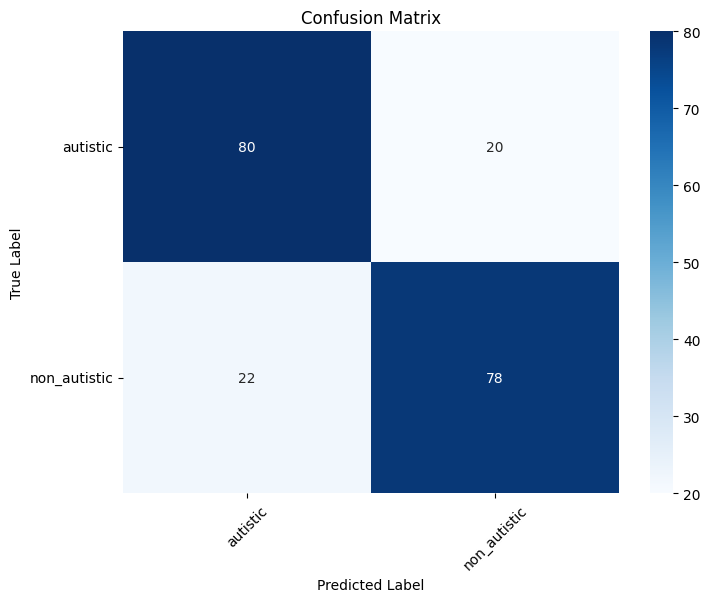

In [ ]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the transforms for evaluation
data_transforms_res = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.CenterCrop(224),      # Center crop
    transforms.ToTensor(),           # Convert to tensor
])

# Load the dataset for evaluation
eval_dataset = ImageFolder('/content/drive/MyDrive/MP_Dataset/autism/test', transform=data_transforms_res)

# Create DataLoader for evaluation
eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=False)

# Load the MobileNetV3 model
model = EfficientNET('b3',2).to(device)
checkpoint = torch.load('/content/drive/MyDrive/MP_Dataset/SpectrumSense/Model_checkpoints/EfficientNET/Efficientnet_b3_70epochs_wr.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize lists to store predictions and ground truth labels
all_preds = []
all_labels = []

# Iterate over the evaluation dataset
for inputs, labels in eval_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)

    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

# Calculate evaluation metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print("Specificity:", specificity)
print(conf_matrix)
classes = eval_dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import torch.nn.functional as F

model_save_path = '/content/drive/MyDrive/MP_Dataset/SpectrumSense/Model_checkpoints/EfficientNET/Efficientnet_b3_70epochs_wr.pth'

# Path to the test image
test_image_path = '/content/drive/MyDrive/MP_Dataset/autism/test/non_autistic/050.jpg'


data_transforms_test = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
])


model = EfficientNET('b3',2)
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval() # Set the model to evaluation mode
model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Load and transform the test image
image = Image.open(test_image_path)
image = data_transforms_test(image).unsqueeze(0)

image = image.to(device)

# Make a prediction
with torch.no_grad():
    outputs = model(image)
    probabilities = F.softmax(outputs, dim=1)
    _, preds = torch.max(probabilities, 1)

class_names = ['Not Autistic', 'Autistic']

# Predicted class name
predicted_class = class_names[preds.item()]

# Print the probabilities of confidence rate for each class
print(f'Predicted class: {predicted_class}')
print(f'Probabilities: {probabilities.tolist()}')


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.